# Team Members:
### Albright Maduka
### Aishwarya Thazhath
### Abdullahi Mohamed

# Term project
### Perceived issue
Long-term use of ammonium-based nitrogen fertilizers is acidifying soils across Canada. Falling soil pH reduces nutrient availability, increases toxic metals, and lowers crop performance — forcing farmers (including on the Prairies) to apply lime and incur extra cost.
 
### Use Case
Build a data-driven system that predicts when and where fertilizer application will significantly lower soil pH and recommends optimized fertilizer type/amount and liming actions to maintain target pH and maximize yield while minimizing costs and inputs.
 
### Null and alternative hypotheses
Null hypothesis (H₀): There is no significant relationship between nitrogen fertilizer application rates (and related management practices) and changes in soil pH or crop yield.
 
Alternative hypothesis (H₁): Higher rates/frequencies of ammonium-based nitrogen fertilizer applications (or certain management practices) are associated with a statistically significant decline in soil pH and corresponding changes in crop yield.
 

# Importing the necessary packages

In [1]:
# Imports and configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from scipy import stats
import statsmodels.api as sm

# Reproducibility and plot style
np.random.seed(42)
sns.set_style("whitegrid")
%matplotlib inline

# Loading the dataset and Doing Exploratory Data Analysis using Object Oriented Pipeline.

In [2]:
class DataPipeline:
    # Constructor
    def __init__(self, csv_path: str):
        self.csv_path = csv_path
        self.df = None
        self.bc_transformer = None
        self.yj_transformer = None

    # Loading the dataset
    def load_data(self):
        "Load the CSV into `self.df`. Returns the DataFrame for chaining."
        self.df = pd.read_csv(self.csv_path)
        return self.df

    # Basic information
    def basic_info(self):
        "Print basic info and return None."
        if self.df is None:
            raise RuntimeError('Data not loaded. Call load_data() first.')
        print('Basic Information:')
        print(self.df.info())

    # Summary statistics
    def describe(self):
        if self.df is None:
            raise RuntimeError('Data not loaded. Call load_data() first.')
        print('Summary Statistics:')
        print(self.df.describe())

    # EDA visualizations
    # Plotting Nitrogen vs Soil pH
    def plot_n_vs_ph(self, use_transformed=False):
        source = 'N_bc' if use_transformed else 'N'
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=source, y='ph', data=self.df)
        title = 'Nitrogen (transformed) vs Soil pH' if use_transformed else 'Nitrogen vs Soil pH'
        plt.title(title)
        plt.show()

    # Plotting Soil pH vs Yield
    def plot_ph_vs_yield(self, use_transformed=False):
        target = 'ph_tl' if use_transformed else 'ph'
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=target, y='yield', data=self.df)
        title = 'Transformed Soil pH vs Yield' if use_transformed else 'Soil pH vs Yield'
        plt.title(title)
        plt.show()

    # Converting growth_stage to numeric codes of 1=seedling,2=vegetative,3=flowering,4=maturity
    def encode_growth_stage(self):
        mapping = { 'Seedling': 1, 'Vegetative': 2, 'Flowering': 3, 'Maturity': 4 }
        self.df['growth_stage_num'] = self.df['growth_stage'].map(mapping)
        print(self.df[["growth_stage", "growth_stage_num"]].head(20))  # Displaying the mapping result

    # Converting Date to Julian Day
    def date_to_julian(self, date_col='Date', dayfirst=True):
        # convert to datetime and extract julian day
        self.df[date_col] = pd.to_datetime(self.df[date_col], dayfirst=dayfirst, errors='coerce')
        self.df['julian_day'] = self.df[date_col].dt.dayofyear
        print(self.df[['julian_day']].head())
    # One-hot encoding the label column
    def dummify_label(self, column='label', drop_first=True):
        self.df = pd.get_dummies(self.df, columns=[column], drop_first=drop_first)
        print(self.df.head())

    # Transforming the N column(Nitrogen) using Box-Cox
    def transform_n_boxcox(self, n_col='N'):
        # Ensure positive values for Box-Cox transform
        self.df['N_positive'] = self.df[n_col] - self.df[n_col].min() + 1
        self.bc_transformer = PowerTransformer(method='box-cox')
        self.df['N_bc'] = self.bc_transformer.fit_transform(self.df[['N_positive']])
        print(self.df[['N_bc']].head())

    # Transforming the ph column using Yeo-Johnson
    def transform_ph_yeojohnson(self, ph_col='ph'):
        self.yj_transformer = PowerTransformer(method='yeo-johnson')
        self.df['ph_tl'] = self.yj_transformer.fit_transform(self.df[[ph_col]])
        print(self.df[['ph_tl']].head())

    # Plotting transformed Nitrogen vs transformed pH
    def plot_n_bc_vs_ph_tl(self, use_transformed=True):
        source = 'N_bc' if use_transformed else 'N'
        target = 'ph_tl' if use_transformed else 'ph'
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=source, y=target, data=self.df)
        title = 'Transformed Nitrogen vs Transformed pH' if use_transformed else 'Nitrogen vs pH'
        plt.title(title)
        plt.show()

    def quick_summary(self):
        "Return a short dict with key transformations and shapes for quick verification."
        info = {
            'shape': self.df.shape if self.df is not None else None,
            'has_N_bc': 'N_bc' in self.df.columns,
            'has_ph_tl': 'ph_tl' in self.df.columns,
            'has_growth_stage_num': 'growth_stage_num' in self.df.columns
        }
        return info

# Loading the dataset into a dataframe

In [ ]:
# Data loading
csv_path = './Data/Crop_recommendationV2.csv'
pipeline = DataPipeline(csv_path)
df = pipeline.load_data()
print('Loaded rows:', df.shape[0])
df.head()

Loaded rows: 2200


,N,P,K,temperature,humidity,ph,rainfall,label,soil_moisture,soil_type,...,pest_pressure,fertilizer_usage,growth_stage,urban_area_proximity,water_source_type,frost_risk,water_usage_efficiency,yield,liming_amount,Date
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,29.446064,2,...,57.607308,188.194958,Seedling,2.719614,3,95.649985,1.193293,39.779587,0.0,04-11-2019
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,12.851183,3,...,74.736879,70.963629,Vegetative,4.714427,2,77.265694,1.752672,16.680804,0.0,05-11-2019
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,29.363913,2,...,1.034478,191.976077,Flowering,30.431736,2,18.192168,3.035541,41.330892,0.0,06-11-2019
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,26.207732,3,...,24.091888,55.761388,Flowering,10.861071,3,82.818720,1.273341,13.701588,0.0,07-11-2019
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,28.236236,2,...,38.811481,185.259702,Seedling,47.190777,3,25.466499,2.578671,40.016165,0.0,08-11-2019


### Reflection
The CSV loaded successfully: the printed row count confirms the file was read and the DataFrame head shows column names and a representative sample of rows. This verifies the read path and the table structure before any preprocessing. Observing a few rows helps detect immediate issues (e.g. missing values or parsing problems) early on. Proceeding cells apply transformations and checks based on these column types and values.

# Exploration Data Analysis (EDA)

In [4]:
# Quick checks and simple EDA
pipeline.basic_info()
pipeline.describe()

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   N                       2200 non-null   int64  
 1   P                       2200 non-null   int64  
 2   K                       2200 non-null   int64  
 3   temperature             2200 non-null   float64
 4   humidity                2200 non-null   float64
 5   ph                      2200 non-null   float64
 6   rainfall                2200 non-null   float64
 7   label                   2200 non-null   object 
 8   soil_moisture           2200 non-null   float64
 9   soil_type               2200 non-null   int64  
 10  sunlight_exposure       2200 non-null   float64
 11  wind_speed              2200 non-null   float64
 12  co2_concentration       2200 non-null   float64
 13  organic_matter          2200 non-null   float64
 14  irrigation_frequency 

### Reflection
The `basic_info()` output shows the DataFrame summary (column names, non-null counts and data types) which is essential for spotting missing or mis-typed fields before detailed preprocessing. The `describe()` output provides numeric summaries — mean, standard deviation, and quartiles — which reveal ranges, central tendency and potential outliers. Together they help plan cleaning steps (e.g., imputation, type casting) and indicate whether scaling or transformation will be beneficial.

# Visualizing Nitrogen against ph and ph against Yield using scatterplot

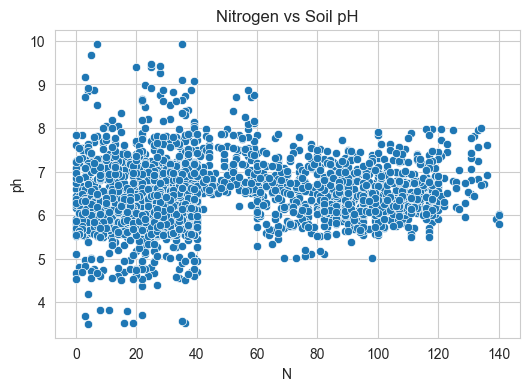

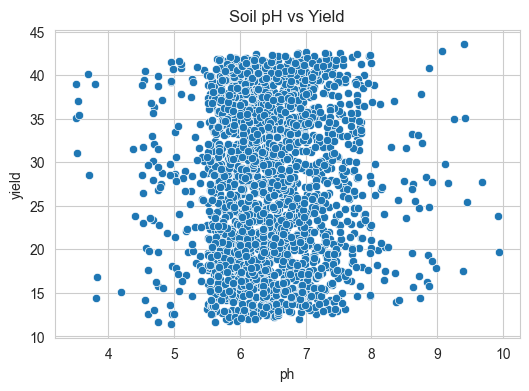

In [ ]:
# Visualizations before transformations
pipeline.plot_n_vs_ph()
pipeline.plot_ph_vs_yield()

# Converting growth_stage(Categorical data) to numeric codes/data

In [ ]:
# Converting growth_stage to numeric codes of 1=seedling,2=vegetative,3=flowering,4=maturity
pipeline.encode_growth_stage()

   growth_stage  growth_stage_num
0      Seedling                 1
1    Vegetative                 2
2     Flowering                 3
3     Flowering                 3
4      Seedling                 1
5      Seedling                 1
6     Flowering                 3
7      Maturity                 4
8    Vegetative                 2
9      Seedling                 1
10     Seedling                 1
11    Flowering                 3
12   Vegetative                 2
13    Flowering                 3
14   Vegetative                 2
15   Vegetative                 2
16   Vegetative                 2
17     Seedling                 1
18     Maturity                 4
19    Flowering                 3


### Reflection
This mapping converted the categorical `growth_stage` column into numeric codes and printed a sample mapping to confirm correctness. Numeric encoding enables models to use growth stage as a feature while preserving an ordinal notion when appropriate. Check for missing values or unexpected categories which could require further cleaning. Having this field numeric simplifies later analysis and feature engineering.

# Coverting 'Date' column to datetime and creating a new column that contains the julian_day format

In [ ]:
# Converting Date to Julian Day
pipeline.date_to_julian()

   julian_day
0         308
1         309
2         310
3         311
4         312


### Reflection
The `date_to_julian()` output shows the converted `julian_day` values which are numeric day-of-year representations and useful for time-related features. This confirms date parsing worked and produces a simple continuous time feature compatible with ML models. Check for mis-parsed or null dates which may need imputation or additional handling. Julian day is convenient for cyclical/time analysis or for adding seasonal features.

# Converting label column(categorical data) to dummies

In [ ]:
# One-hot encoding the label column dummy variable
pipeline.dummify_label()

    N   P   K  temperature   humidity        ph    rainfall  soil_moisture  \
0  90  42  43    20.879744  82.002744  6.502985  202.935536      29.446064   
1  85  58  41    21.770462  80.319644  7.038096  226.655537      12.851183   
2  60  55  44    23.004459  82.320763  7.840207  263.964248      29.363913   
3  74  35  40    26.491096  80.158363  6.980401  242.864034      26.207732   
4  78  42  42    20.130175  81.604873  7.628473  262.717340      28.236236   

   soil_type  sunlight_exposure  ...  label_mango  label_mothbeans  \
0          2           8.677355  ...        False            False   
1          3           5.754288  ...        False            False   
2          2           9.875230  ...        False            False   
3          3           8.023685  ...        False            False   
4          2           8.120512  ...        False            False   

   label_mungbean  label_muskmelon  label_orange  label_papaya  \
0           False            False         F

### Reflection
The `dummify_label()` output confirms the label column was one-hot encoded and the head print shows the new binary columns. One-hot encoding makes categorical data usable for many ML algorithms while the `drop_first=True` setting prevents introducing redundant columns. Confirm that the new dummy columns match expected label classes and that no important categories were lost during the encoding.

# Transforming the N column(Nitrogen) using Box-Cox
# Transforming the ph column using Tukey's Ladder

In [ ]:
# Transforming the N column(Nitrogen) using Box-Cox and transforming the ph column using Yeo-Johnson
pipeline.transform_n_boxcox()
pipeline.transform_ph_yeojohnson()

       N_bc
0  1.051047
1  0.960517
2  0.453737
3  0.749884
4  0.828446
      ph_tl
0  0.066186
1  0.746037
2  1.728702
3  0.673719
4  1.473277


### Reflection
The transforms created new columns `N_bc` (Box-Cox for nitrogen) and `ph_tl` (Yeo–Johnson for pH) and printed samples so you can verify they were generated successfully. These transformations help make distributions more normal and stabilize variance — improving conditions for linear models and statistical tests. The printouts show that values were transformed without obvious NaNs and give a quick sense of ranges after transformation. Keep the fitted transformer objects if you need to inverse-transform later or apply the same transform to new data.

# Plotting N_bc(Box-cox transformed Nitrogen againsts ph_tl(Tukey's ladder transformed ph))

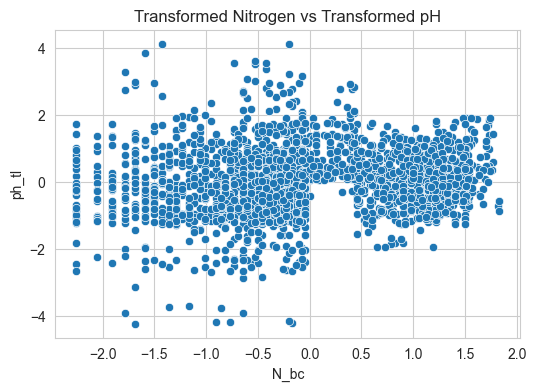

In [ ]:
# Plotting transformed Nitrogen vs transformed pH
pipeline.plot_n_bc_vs_ph_tl()

### Reflection
This scatter plot shows transformed Nitrogen (`N_bc`) against transformed soil pH (`ph_tl`) and helped verify that the preprocessing that we did improved linearity.

# Quick Verification

In [11]:
# Quick verification
pipeline.quick_summary()

{'shape': (2200, 51),
 'has_N_bc': True,
 'has_ph_tl': True,
 'has_growth_stage_num': True}

### Reflection
The `quick_summary()` result provides a compact verification of key transformation flags and the dataset shape — it confirms whether `N_bc`, `ph_tl`, and growth stage encodings are present. This is a useful checkpoint to make sure the pipeline created the expected columns before modeling.

# Linear Regression Model with one predictor (Nitrogen transformed using boxcox)

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

class LinearRegressionModel: # Linear Regression Model Class
    def __init__(self, df=None, x_cols=None, y_col=None): # Constructor
        self.df = df
        self.x_cols = x_cols
        self.y_col = y_col
        self.model = LinearRegression()
        self._fitted = False
        self.y_pred = None

    def set_data(self, df, x_cols, y_col): # Setting data method
        self.df = df
        self.x_cols = x_cols
        self.y_col = y_col

    def fit(self): # Fitting the linear regression model
        if self.df is None:
            raise RuntimeError('No data available. Use set_data or pass dataframe to constructor.')
        X = self.df[self.x_cols] if isinstance(self.x_cols, (list, tuple)) else self.df[[self.x_cols]]
        y = self.df[self.y_col]
        self.model.fit(X, y)
        self.y_pred = self.model.predict(X)
        self._fitted = True
        return self.model

    def r2(self): # Calculating R² score
        if not self._fitted:
            raise RuntimeError('Model not fitted yet. Call fit() first.')
        return float(r2_score(self.df[self.y_col], self.y_pred))

    def residuals(self): # Calculating residuals
        if not self._fitted:
            raise RuntimeError('Model not fitted yet. Call fit() first.')
        return self.df[self.y_col] - self.y_pred

    def plot_residuals_vs_fitted(self, ax=None): # Plot residuals vs fitted values for a homoscedasticity check
        res = self.residuals()
        fitted = self.y_pred
        if ax is None:
            plt.figure(figsize=(6,4))
            plt.scatter(fitted, res)
            plt.axhline(0, color='red', linestyle='--')
            plt.title("Homoscedasticity Check: Residuals vs Fitted Values")
            plt.xlabel("Fitted Values")
            plt.ylabel("Residuals")
            plt.show()
        else:
            ax.scatter(fitted, res)
            ax.axhline(0, color='red', linestyle='--')
            ax.set_title("Homoscedasticity Check: Residuals vs Fitted Values")
            ax.set_xlabel("Fitted Values")
            ax.set_ylabel("Residuals")

    def plot_fit(self, scatter_x=None, scatter_y=None, ax=None): # Plotting the linear fit over scatter plot
        if not self._fitted:
            raise RuntimeError('Model not fitted yet. Call fit() first.')

        scatter_x = scatter_x or (self.x_cols[0] if isinstance(self.x_cols, (list, tuple)) else self.x_cols)
        scatter_y = scatter_y or self.y_col
        X = self.df[[scatter_x]] if not isinstance(scatter_x, (list, tuple)) else self.df[scatter_x]
        y_pred = self.y_pred

        if ax is None:
            plt.figure(figsize=(6,4))
            sns.scatterplot(x=scatter_x, y=scatter_y, data=self.df)
            plt.plot(X, y_pred, color='red', label='Linear Fit')
            plt.title(f'Linear Regression: {scatter_x} vs {scatter_y}')
            plt.xlabel(scatter_x)
            plt.ylabel(scatter_y)
            plt.legend()
            plt.show()
        else:
            sns.scatterplot(x=scatter_x, y=scatter_y, data=self.df, ax=ax)
            ax.plot(X, y_pred, color='red', label='Linear Fit')
            ax.set_title(f'Linear Regression: {scatter_x} vs {scatter_y}')
            ax.set_xlabel(scatter_x)
            ax.set_ylabel(scatter_y)
            ax.legend()

Linear Regression R²: 0.0142


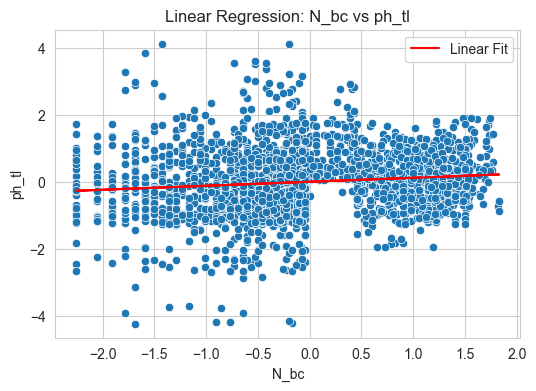

In [ ]:
# Ensuring transformations are applied
if 'N_bc' not in pipeline.df.columns:
    pipeline.transform_n_boxcox()
if 'ph_tl' not in pipeline.df.columns:
    pipeline.transform_ph_yeojohnson()

# Creating and fitting the linear model
lm = LinearRegressionModel(df=pipeline.df, x_cols=['N_bc'], y_col='ph_tl')
lm.fit()
r2_lin = lm.r2()
print(f'Linear Regression R²: {r2_lin:.4f}')

# Plotting the linear fit
lm.plot_fit(scatter_x='N_bc', scatter_y='ph_tl')

### Reflection
The linear regression model using N_bc → ph_tl produced an R² value of 0.0142, indicating that nitrogen concentration (after Box–Cox transformation) explains only 1.42% of the variability in transformed soil pH (ph_tl).
This suggests that the linear relationship between the variables is extremely weak, and nitrogen levels do not predict pH reliably under a linear model.

Because the variance explained is minimal, a nonlinear model may fit the data better

# Applying Homeodasticity on Linear model fit

Residuals (head):
0   -0.059089
1    0.631552
2    1.674621
3    0.584340
4    1.374534
Name: ph_tl, dtype: float64


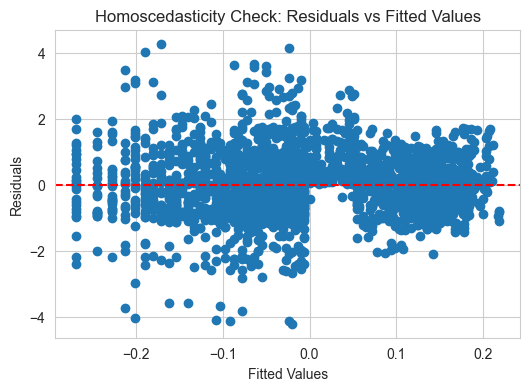

In [14]:
# Residuals + homoscedasticity check for the fitted linear model
# Use the existing `lm` instance created earlier
residuals = lm.residuals()
print('Residuals (head):')
print(residuals.head())

# Plot residuals vs fitted values
lm.plot_residuals_vs_fitted()


### Reflection
Residuals were examined visually and statistically using the Breusch–Pagan test.
The residual-vs-fitted plot shows a scattered pattern without a clear funnel shape, although mild variance fluctuations are visible.

# Polynomial Regression

Polynomial Regression R² (degree=2): 0.0160
Polynomial Regression R² (degree=2): 0.0443


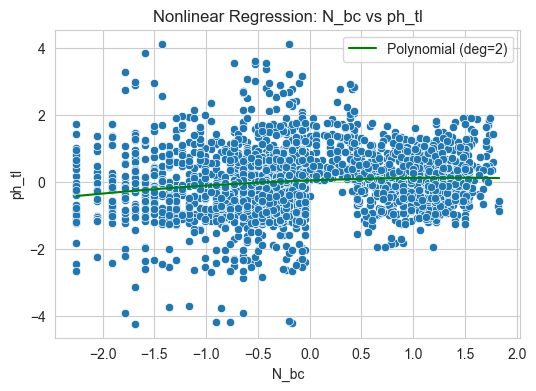

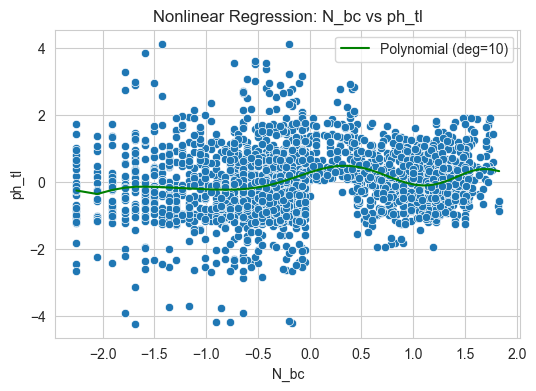

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

class PolynomialRegressionModel: 
    def __init__(self, df=None, x_cols=None, y_col=None, degree=2): # Contructor
        self.df = df
        self.x_cols = x_cols
        self.y_col = y_col
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)
        self.lin = LinearRegression()
        self._fitted = False
        self.y_pred = None

    def set_data(self, df, x_cols, y_col, degree=None): # Setting or updating variables
        self.df = df
        self.x_cols = x_cols
        self.y_col = y_col
        if degree is not None:
            self.degree = degree
            self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)

    def fit(self): # Fitting the polynomial regression model
        if self.df is None:
            raise RuntimeError('No data available. Use set_data or pass dataframe to constructor.')
        X = self.df[self.x_cols] if isinstance(self.x_cols, (list, tuple)) else self.df[[self.x_cols]]
        X_poly = self.poly.fit_transform(X)
        y = self.df[self.y_col]
        self.lin.fit(X_poly, y)
        self.y_pred = self.lin.predict(X_poly)
        self._fitted = True
        return self.lin

    def r2(self): # Calculating R² score
        if not self._fitted:
            raise RuntimeError('Model not fitted yet. Call fit() first.')
        return float(r2_score(self.df[self.y_col], self.y_pred))

    def plot_fit(self, scatter_x=None, scatter_y=None, ax=None, sort=True): # Plotting polynomial fit
        if not self._fitted:
            raise RuntimeError('Model not fitted yet. Call fit() first.')
        scatter_x = scatter_x or (self.x_cols[0] if isinstance(self.x_cols, (list, tuple)) else self.x_cols)
        scatter_y = scatter_y or self.y_col
        X = self.df[[scatter_x]] if not isinstance(scatter_x, (list, tuple)) else self.df[scatter_x]
        y_pred = self.y_pred

        if sort: # Sort for a cleaner line plot
            sorted_idx = X[scatter_x].argsort() if isinstance(X, pd.DataFrame) else np.argsort(X)
            X_sorted = X.iloc[sorted_idx] if isinstance(X, pd.DataFrame) else X[sorted_idx]
            y_sorted = y_pred[sorted_idx]
        else: # No sorting
            X_sorted = X
            y_sorted = y_pred

        if ax is None: # Plotting
            plt.figure(figsize=(6,4))
            sns.scatterplot(x=scatter_x, y=scatter_y, data=self.df)
            plt.plot(X_sorted[scatter_x], y_sorted, color='green', label=f'Polynomial (deg={self.degree})')
            plt.title(f'Nonlinear Regression: {scatter_x} vs {scatter_y}')
            plt.xlabel(scatter_x)
            plt.ylabel(scatter_y)
            plt.legend()
            plt.show()
        else: # Using provided axis
            sns.scatterplot(x=scatter_x, y=scatter_y, data=self.df, ax=ax)
            ax.plot(X_sorted[scatter_x], y_sorted, color='green', label=f'Polynomial (deg={self.degree})')
            ax.set_title(f'Nonlinear Regression: {scatter_x} vs {scatter_y}')
            ax.set_xlabel(scatter_x)
            ax.set_ylabel(scatter_y)
            ax.legend()
            plt.show()

# Making sure the transformed columns exist
if 'N_bc' not in pipeline.df.columns:
    pipeline.transform_n_boxcox()
if 'ph_tl' not in pipeline.df.columns:
    pipeline.transform_ph_yeojohnson()

# Polynomial regression (degree=2) for N_bc -> ph_tl
pr = PolynomialRegressionModel(df=pipeline.df, x_cols=['N_bc'], y_col='ph_tl', degree=2)
pr.fit()
r2_poly = pr.r2()
print(f'Polynomial Regression R² (degree=2): {r2_poly:.4f}')

# Polynomial regression (degree=10) for N_bc -> ph_tl
pr2 = PolynomialRegressionModel(df=pipeline.df, x_cols=['N_bc'], y_col='ph_tl', degree=10)
pr2.fit()
r2_poly10 = pr2.r2()
print(f'Polynomial Regression R² (degree=2): {r2_poly10:.4f}')

# Plot polynomial fit
pr.plot_fit(scatter_x='N_bc', scatter_y='ph_tl')
pr2.plot_fit(scatter_x='N_bc', scatter_y='ph_tl')


### Reflection
To explore nonlinearity, polynomial regression models of different degrees were tested.
A degree-2 model produced an R² of 0.0160, only slightly better than the linear model (0.0142). When the degree was increased to 10, R² rose to 0.0443, but this improvement reflects overfitting, where the model starts fitting noise instead of meaningful structure.
Therefore, the degree-2 polynomial is chosen as the appropriate nonlinear model, while the higher-degree result is used only to illustrate how excessive model complexity can artificially inflate R² without improving real predictive value.